<a href="https://colab.research.google.com/github/Ethel-Ogallo/multitask_regression_deeplearning/blob/master/Multi_task_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Multi-Task Regression Using ResNet50

This notebook demonstrates a **supervised multi-task regression** workflow for remote sensing using **TorchGeo** using the Digital Typhoon dataset, which consists of infrared (IR) satellite imagery of tropical cyclones paired with meteorological measurements.

The objective is to predict multiple continuous typhoon intensity variables from satellite imagery using a deep learning model.  

### Dataset Overview
The [Digital Typhoon](https://torchgeo.readthedocs.io/en/stable/api/datasets.html#digital-typhoon) is derived from hourly infrared channel observations captured by multiple generations of the Himawari meteorological satellites, spanning the period from 1978. The satellite measurements have been converted to brightness temperatures and normalized across different sensors, resulting in a consistent spatio-temporal dataset covering more than four decades.  

**Dataset features:**
- Infrared (IR) satellite imagery of 512 × 512 pixels at ~5km resolution
- Auxiliary metadata including wind speed, pressure and additional typhoon-related attributes  
- 1,099 typhoons and 189,364 images

**References**  
1. Machine Learning for the Digital Typhoon Dataset:
Extensions to Multiple Basins and New Developments
in Representations and Tasks: [arXiv:2411.16421](https://arxiv.org/pdf/2411.16421)  
2. Digital Typhoon: Long-term Satellite Image Dataset
for the Spatio-Temporal Modeling of Tropical Cyclones: [arXiv:2311.02665](https://arxiv.org/pdf/2311.02665)

*notes from paper:*  
*the images feature a 2D array of brightness temperatures around the typhoon’s center, formatted in HDF5*

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install torchgeo --quiet
!pip install wandb --quiet

In [ ]:
## import package
import os
import shutil
import pandas as pd
import numpy as np
import random
import torch
import matplotlib.pyplot as plt
from datetime import datetime

import torch.nn as nn
from torch.utils.data import DataLoader, Subset

from torchvision import transforms
from torchvision import models
from torchvision.transforms import Resize

from torchgeo.datasets import DigitalTyphoon
from torchgeo.datamodules import DigitalTyphoonDataModule
from torchgeo.trainers import RegressionTask
from torchgeo.models import resnet50, ResNet50_Weights

import pytorch_lightning as pl
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
from lightning.pytorch.loggers import WandbLogger


In [ ]:
# load dataset
root = "/home/ogallo/DL4CV/DigitalTyphoon"

dataset = DigitalTyphoon(
    root=root,
    features=["wind", "pressure"],
    targets=["wind", "pressure"],
    sequence_length=1,
    download=False
)


In [ ]:
print(len(dataset))        # number of sequences
print(dataset[0])          # inspect the first sequence

173418
{'image': tensor([[[0.7248, 0.7813, 0.7813,  ..., 0.9331, 0.9363, 0.9331],
         [0.7248, 0.7576, 0.7735,  ..., 0.9331, 0.9331, 0.9331],
         [0.7290, 0.7536, 0.7656,  ..., 0.9299, 0.9299, 0.9331],
         ...,
         [0.6904, 0.6495, 0.6007,  ..., 0.8483, 0.8798, 0.8659],
         [0.6542, 0.6400, 0.6725,  ..., 0.8483, 0.8659, 0.8447],
         [0.7373, 0.7536, 0.7967,  ..., 0.8518, 0.8518, 0.8483]]]), 'wind': tensor(-1.1229), 'pressure': tensor(0.5422), 'label': tensor([-1.1229,  0.5422])}


In [ ]:
aux_data = pd.read_csv("/home/ogallo/DL4CV/DigitalTyphoon/WP/aux_data.csv")
print(aux_data.head())     # inspect auxiliary data

       id                   image_path  year  month  day  hour  grade    lat  \
0  197830  1978120100-197830-GMS1-1.h5  1978     12    1     0      6  36.00   
1  197830  1978120103-197830-GMS1-1.h5  1978     12    1     3      6  37.46   
2  197830  1978120106-197830-GMS1-1.h5  1978     12    1     6      6  39.00   
3  197901  1978123112-197901-GMS1-1.h5  1978     12   31    12      2   2.00   
4  197901  1978123116-197901-GMS1-1.h5  1978     12   31    16      2   2.30   

      lng  pressure  wind  dir50  long50  short50  dir30  long30  short30  \
0  174.00     996.0   0.0      0       0        0      0       0        0   
1  176.44     994.0   0.0      0       0        0      0       0        0   
2  179.00     992.0   0.0      0       0        0      0       0        0   
3  172.00    1004.0   0.0      0       0        0      0       0        0   
4  171.81    1002.7   0.0      0       0        0      0       0        0   

   landfall  intp  
0         0     0  
1         0     

#### Subset the dataset
This is based on the typhoon event. We choose 1% of the typhoons i.e. 100 and then stratify teh images based on grade and lifecycle??

In [ ]:
# Import the sampling functions
from sample_v2 import load_data, sample_typhoons, sample_images, copy_images, save_sampled_data, copy_metadata

# Set paths and parameters
root = "/home/ogallo/DL4CV/DigitalTyphoon/WP"
output_dir = "/home/ogallo/DL4CV/WP_sampled_10pct"
total_typhoons = 110

# Load data
df = load_data(root)
print(f"Loaded {len(df)} records from {df['id'].nunique()} typhoons.")
print(f"Year range: {df['year'].min()} - {df['year'].max()}")

# Sample typhoons (distributed across years)
sampled_typhoons = sample_typhoons(df, total_typhoons, seed=42)
print(f"\nSelected {len(sampled_typhoons)} typhoons.")

# Sample all images for selected typhoons (no cap)
df_sampled = sample_images(df, sampled_typhoons)
print(f"Sampled {len(df_sampled)} images across {df_sampled['id'].nunique()} typhoons.")

# Copy images
copied, not_found = copy_images(df_sampled, root, output_dir)
print(f"\nCopied {copied}/{len(df_sampled)} images.")
if not_found:
    print(f"Warning: {len(not_found)} images not found.")

# Save sampled data
save_sampled_data(df_sampled, output_dir)
print(f"Saved aux_data.csv")

# Copy metadata
sampled_typhoon_ids = sorted(df_sampled['id'].unique())
copy_metadata(root, output_dir, sampled_typhoon_ids)
print(f"Copied and filtered metadata.")

Loaded 189364 records from 1099 typhoons.
Year range: 1978 - 2022

Selected 110 typhoons.
Sampled 18686 images across 110 typhoons.

Copied 18686/18686 images.
Saved aux_data.csv
Copied and filtered metadata.


## start colab

In [ ]:
dataset = DigitalTyphoon(
    root="/content/drive/MyDrive/DL4CV/WP_sampled_10pct",
    features=["wind", "pressure"],
    targets=["wind", "pressure"],
    sequence_length=1,
    download=False
)

In [ ]:
dataset.__len__
dataset.__getitem__(index=0)

{'image': tensor([[[0.9183, 0.8847, 0.8538,  ..., 0.9072, 0.9146, 0.8961],
          [0.9292, 0.9292, 0.9292,  ..., 0.9219, 0.9146, 0.8961],
          [0.9328, 0.9292, 0.9292,  ..., 0.9146, 0.8998, 0.8809],
          ...,
          [0.8733, 0.8809, 0.9035,  ..., 0.2863, 0.2863, 0.2754],
          [0.8961, 0.9035, 0.9183,  ..., 0.2754, 0.2863, 0.2643],
          [0.9146, 0.9219, 0.9183,  ..., 0.2754, 0.2754, 0.2754]]]),
 'wind': tensor(-1.1465),
 'pressure': tensor(1.0046),
 'label': tensor([-1.1465,  1.0046])}

In [ ]:
# sample = dataset.__getitem__(index=0)
# dataset.plot(sample)

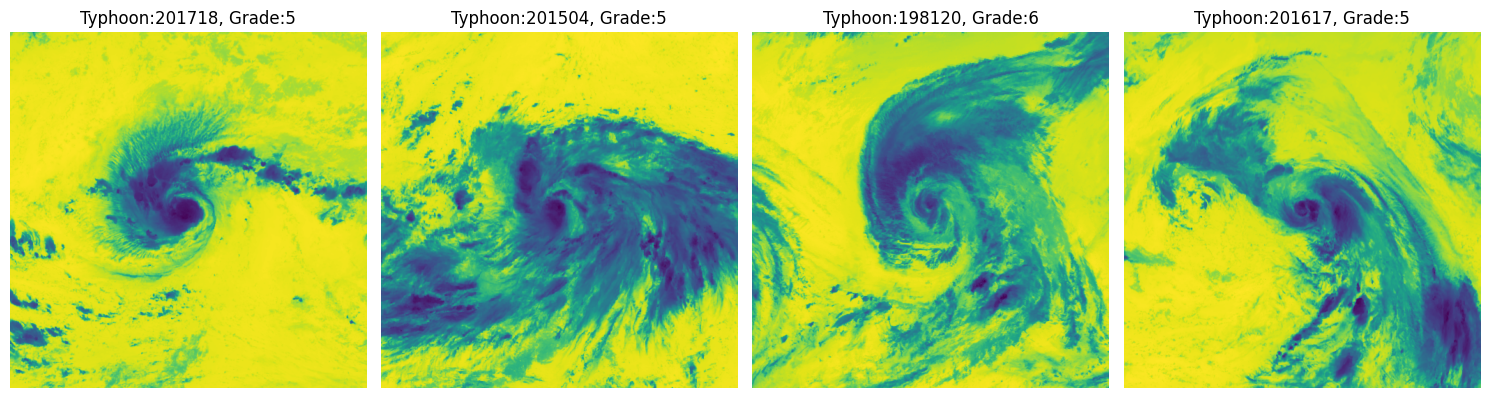

In [ ]:
# visualize input
aux_df = pd.read_csv("/content/drive/MyDrive/DL4CV/WP_sampled_10pct/WP/aux_data.csv")
aux_df = aux_df.reset_index(drop=True)

# random indices
indices = np.random.choice(len(dataset), size=4, replace=False)

plt.figure(figsize=(15, 4))
for i, idx in enumerate(indices):
    sample = dataset[idx]
    image = sample['image'].squeeze()
    wind = sample['wind']
    pressure = sample['pressure']

    row = aux_df.iloc[idx] # Lookup metadata from aux_df
    typhoon_id = row['id']
    grade = row['grade']

    plt.subplot(1, 4, i + 1)
    plt.imshow(image, cmap='viridis')
    plt.title(f"Typhoon:{typhoon_id}, Grade:{grade}")
    plt.suptitle(f"Wind:{wind:.3f}, Pressure:{pressure:.3f}")
    plt.axis('off')

plt.tight_layout()
plt.show()


### ResNet50
understand and explain model architecture with 2 head for multitask regression (add pic/infograph if possible)

in markdown also include what we will do train, val and test then tuning???
 we resize from 512x512 to 224x224 , resnet default + memory issues

**wandb logger?? torchgeo.logger......

In [ ]:
# set seed
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)                # CPU
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)       # Single GPU
        torch.cuda.manual_seed_all(seed)   # Multi-GPU
set_seed(42)

# Make CUDA deterministic
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False



### Data Prep: normalize data and resize images

In [ ]:
# compute stats
def compute_and_save_stats(dataset, target_names, save_path="/content/drive/MyDrive/DL4CV/WP_sampled_10pct/digital_typhoon_stats.pt"):
    stats = {name: [] for name in target_names}

    # Running mean/std for IR images
    count = 0
    mean = 0.0
    m2 = 0.0

    resize = Resize((224, 224))  # resize for faster stats computation

    for sample in dataset:
        # Targets
        for name in target_names:
            stats[name].append(sample[name])

        # Image: resize to 224x224 to reduce compute
        img = resize(sample["image"]).float()
        pixels = img.numel()
        img_mean = img.mean()
        img_var = img.var(unbiased=False)

        # Online update
        delta = img_mean - mean
        mean += delta * pixels / (count + pixels)
        m2 += img_var * pixels + delta**2 * count * pixels / (count + pixels)
        count += pixels

    # Final IR stats
    ir_mean = mean
    ir_std = (m2 / count)**0.5

    # Targets
    for name in target_names:
        vals = torch.tensor(stats[name], dtype=torch.float32)
        stats[name] = {"mean": vals.mean(), "std": vals.std()}

    # Save stats
    stats_dict = {
        "target_stats": stats,
        "ir_mean": ir_mean,
        "ir_std": ir_std
    }
    torch.save(stats_dict, save_path)

    return stats, ir_mean, ir_std


def load_stats(save_path="digital_typhoon_stats.pt"):
    stats_dict = torch.load(save_path)
    return stats_dict["target_stats"], stats_dict["ir_mean"], stats_dict["ir_std"]

# resize from 512x512
def make_transforms(target_stats, ir_mean, ir_std):
    resize = Resize((224, 224))

    def normalize_targets(sample):
        sample["wind"] = (sample["wind"] - target_stats["wind"]["mean"]) / (target_stats["wind"]["std"] + 1e-6)
        sample["pressure"] = (sample["pressure"] - target_stats["pressure"]["mean"]) / (target_stats["pressure"]["std"] + 1e-6)
        return sample

    def transform_sample(sample):
        img = sample["image"]
        img = resize(img)
        img = (img - ir_mean) / (ir_std + 1e-6)
        if img.shape[0] == 1:
            img = img.repeat(3, 1, 1)
        sample["image"] = img
        sample = normalize_targets(sample)
        return sample

    return transform_sample

# Compute and save stats (once)
target_names = ["wind", "pressure"]
target_stats, ir_mean, ir_std = compute_and_save_stats(dataset, target_names)

# load stats
# target_stats, ir_mean, ir_std = load_stats()

# Make transforms
transform = make_transforms(target_stats, ir_mean, ir_std)


In [ ]:
# initialize datasets
datamodule = DigitalTyphoonDataModule(split_by='typhoon_id',
                                      batch_size=16,
                                      num_workers=0,
                                      download = False,
                                      root = "/content/drive/MyDrive/DL4CV/WP_sampled_10pct",
                                      task = "regression",
                                      features=["wind", "pressure"],
                                      targets=["wind", "pressure"],
                                      sequence_length=1,
                                      transforms = transform
                                      )

In [ ]:
sample = datamodule.train_dataset[0]
print("Image shape:", sample["image"].shape)       # [3, 224, 224]
print("Targets (normalized):", sample["targets"]) # ~0 mean, ~1 std

Train base model with deafult parameters

In [ ]:
# define model architecture

class RegressionTwoHead(pl.LightningModule):
    def __init__(self, learning_rate=1e-4, pretrained=True, freeze_backbone=True):
        """
        Two-head ResNet50 for regression on wind and pressure.

        Args:
            learning_rate: Learning rate for the optimizer.
            pretrained: If True, uses ImageNet pretrained weights for the backbone.
            freeze_backbone: If True, freezes the backbone weights during training.
        """
        super().__init__()
        self.save_hyperparameters()

        # --- Backbone (ResNet50) ---
        weights = ResNet50_Weights.IMAGENET1K_V1 if pretrained else None
        backbone = resnet50(weights=weights)
        if freeze_backbone and pretrained:
            for param in backbone.parameters():
                param.requires_grad = False  # Freeze backbone
        self.backbone = nn.Sequential(*list(backbone.children())[:-1])
        self.flatten = nn.Flatten()

        # --- Heads ---
        feature_size = 2048
        self.head_wind = nn.Sequential(
            nn.Linear(feature_size, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )
        self.head_pressure = nn.Sequential(
            nn.Linear(feature_size, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

        # --- Loss ---
        self.criterion = nn.MSELoss()

    def forward(self, x):
        """Forward pass: backbone + two heads."""
        x = self.backbone(x)
        x = self.flatten(x)
        wind_out = self.head_wind(x)
        pressure_out = self.head_pressure(x)
        return torch.cat([wind_out, pressure_out], dim=1)

    def training_step(self, batch, batch_idx):
        """Training step with MSE loss and logging."""
        imgs, targets = batch["image"], batch["targets"]
        preds = self(imgs)
        loss_wind = self.criterion(preds[:, 0], targets[:, 0])
        loss_pressure = self.criterion(preds[:, 1], targets[:, 1])
        loss = loss_wind + loss_pressure
        self.log_dict({
            "train_loss": loss,
            "train_loss_wind": loss_wind,
            "train_loss_pressure": loss_pressure,
        }, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        """Validation step with MSE loss and logging."""
        imgs, targets = batch["image"], batch["targets"]
        preds = self(imgs)
        loss_wind = self.criterion(preds[:, 0], targets[:, 0])
        loss_pressure = self.criterion(preds[:, 1], targets[:, 1])
        loss = loss_wind + loss_pressure
        self.log_dict({
            "val_loss": loss,
            "val_loss_wind": loss_wind,
            "val_loss_pressure": loss_pressure,
        }, prog_bar=True)
        return loss

    def configure_optimizers(self):
        """Configure Adam optimizer."""
        return torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate)


In [ ]:
# training

def train_model(
    model,
    datamodule,
    max_epochs: int = 20,
    patience: int = 3,
    learning_rate: float = 1e-4,
    model_name: str = "resnet50_twohead",
):
    """
    Train a PyTorch Lightning model with Weights & Biases logging.

    Args:
        model: Your PyTorch Lightning model.
        datamodule: Your PyTorch Lightning DataModule.
        max_epochs: Maximum number of training epochs.
        patience: Patience for early stopping.
        learning_rate: Learning rate for the optimizer.
        model_name: Name of the model for checkpointing.
    """
    # Initialize logger
    wandb_logger = WandbLogger(
        project="DigitalTyphoon",
        name=f"{model_name}_lr{learning_rate}_epochs{max_epochs}",
        log_model=True,
    )

    # Callbacks
    early_stopping = EarlyStopping(monitor="val_loss", patience=patience, mode="min")

    checkpoint_callback = ModelCheckpoint(
        monitor="val_loss",
        mode="min",
        save_top_k=1,
        filename=f"{model_name}-{{epoch:02d}}-{{val_loss:.4f}}",
        dirpath=f"checkpoints/{model_name}",
        auto_insert_metric_name=False,
    )

    # Trainer
    trainer = Trainer(
        max_epochs=max_epochs,
        accelerator="auto",
        devices=1,
        precision=16,
        logger=wandb_logger,
        callbacks=[early_stopping, checkpoint_callback],
    )

    # Train
    trainer.fit(model, datamodule=datamodule)

    return trainer


In [ ]:
# Initialize model
model = RegressionTwoHead(
    learning_rate=1e-4,
    pretrained=True,
    freeze_backbone=True,
)

# Train
trainer = train_model(
    model=model,
    datamodule=datamodule,
    max_epochs=10,
    patience=3,
    model_name="resnet50",
)


In [ ]:
def train_typhoon(
    model_name,
    model_backbone,
    datamodule,           # DigitalTyphoonDataModule
    weights=True,
    lr=1e-4,              # learning rate
    max_epochs=10,        # number of epochs
    patience=10,          # LR scheduler patience
    use_wandb=True        # whether to log to Weights & Biases
):
    """
    Train a ResNet50 regression model on DigitalTyphoon IR data
    predicting 2 continuous targets (wind and pressure).

    Parameters:
        datamodule: TorchGeo DigitalTyphoonDataModule
        lr: float, learning rate
        max_epochs: int, max training epochs
        patience: int, LR scheduler patience
        use_wandb: bool, enable wandb logging
    """

    # Initialize RegressionTask for 2-target regression
    task = RegressionTask(
        model= model_name, #'resnet50',
        backbone= model_backbone, #'resnet50',
        weights=True,          # use ImageNet pretrained weights
        in_channels=1,         # 1-channel IR input
        num_outputs=2,         # 2 regression targets: wind & pressure
        loss='mse',            # mean squared error loss
        lr=lr,
        patience=patience,
        freeze_backbone=False,
        freeze_decoder=False
    )

    # W&B logger
    if use_wandb:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        wandb_logger = WandbLogger(
            project="DigitalTyphoon_DL_Experiments",
            name=f"{model_name}_{timestamp}",
            config={
                "model_name": model_name,
                "lr": lr,
                "max_epochs": max_epochs,
                "patience": patience,
            }
        )
    else:
        wandb_logger = None

    # Setup checkpoint callback (monitor val_loss for regression)
    checkpoint_callback = ModelCheckpoint(
        monitor="val_loss",
        mode="min",
        save_top_k=1,
        filename="best-model-{epoch:02d}-{val_loss:.4f}",
        dirpath=f"checkpoints/{model_name}",
        auto_insert_metric_name=False
    )

    # Initialize Trainer
    trainer = Trainer(
        max_epochs=max_epochs,
        accelerator="auto",  # automatically chooses GPU/CPU
        devices=1,
        logger=wandb_logger,
        callbacks=[checkpoint_callback],
        log_every_n_steps=10,
    )

    # Train the model
    # datamodule.setup(stage="fit")
    trainer.fit(task,
                datamodule=datamodule
                # train_dataloaders=datamodule.train_dataloader(),
                # val_dataloaders=datamodule.val_dataloader(),
                )

    return trainer


In [ ]:
tr1 = train_typhoon(model_name='resnet50',
    model_backbone = 'resnet50',
    datamodule = datamodule,
    weights=True,
    lr=1e-4,
    max_epochs=10,
    patience=3,
    use_wandb=True
)

print(f'model checkpoint: {tr1}')

hyperparameter tuning using optuna MSE loss etc

In [ ]:
# Tuning using optuna


In [ ]:
# train, val metrics plot?

In [ ]:
# inference/evaluate on test